## Pasos para *image stitching*:
- 1. Obtener los *keypoints* (puntos clave, características) con sus descriptores de cada imagen
- 2. Realizar el *matching* (emparejamiento) entre los descriptores de las dos imágenes
- 3. Filtrar los *matches* obtenidos ya que puede haber *matching* que no sean correctas
- 4. Realizar la homografía de una imagen y juntarla con la otra.

## Obtención de los keypoints y descriptores:
- SURF ("surf"): Speeded Up Robust Features - descriptores en coma flotante (*float*)
- SIFT ("sift"): Scale-Invariant Feature Transform descriptors - descriptores en coma flotante (*float*)
- ORB ("O"): Oriented FAST and rotated BRIEF descriptors - descriptores binarios
- FAST + BRIEF ("fast_brief"): *keypoints* mediante FAST y descriptores mediante BRIEF - descriptores binarios

Entre paréntises es el nombre del método implementado en descriptores.py

## Matching de los descriptores:
- "BF": Fuerza bruta sin distancia de Hamming.
- "BF_k": Fuerza bruta sin distancia de Hamming y cogiendo los k vecinos más cercanos.
- "BF_H": Fuerza bruta con distancia de Hamming .
- "BF_H_k": Fuerza bruta con distancia de Hamming y cogiendo los k vecinos más cercanos.

De la lista anterior, los dos primeros se utilizan para SURF y SIFT. Los dos últimos se utilizan para ORB y FAST+BRIEF. Esto se debe a que los descriptores de los primeros son en coma flotante y los segundos en binario. El nombre entre comillas corresponde al nombre implementado en descriptores.py,

## Filtrado de los matches:
- "DIST": se seleccionan los matches cuya distancia sea menor a un umbral (min_distancia).
- "KNN": selecciona los matches cuya diferencia proporcional sea grande entre el primero y el segundo. 

Se utilizará "DIST" cuando el matching se realice mediante "BF" o "BF_H" y se utilizará "KNN" cuando el matching se realice mediante "BF_k" o "BF_H_k".

## Importar las librerías necesarias

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import descriptors

Se leen las imágenes. Se leen en color y se pasan a blanco y negro. Finalmente cuando se junten, mostraremos el resultado en color.

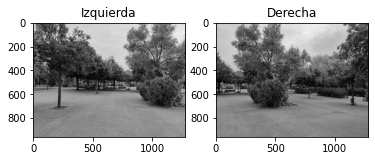

In [2]:
img_L = cv2.imread("../../in/descriptors/olivo_L.jpg")
img_L_g = cv2.cvtColor(img_L, cv2.COLOR_BGR2GRAY)

img_R = cv2.imread("../../in/descriptors/olivo_R.jpg")
img_R_g = cv2.cvtColor(img_R, cv2.COLOR_BGR2GRAY)

plt.subplot(1, 2, 1)
plt.title('Izquierda')
plt.imshow(img_L_g, cmap = 'gray')

plt.subplot(1, 2, 2)
plt.title('Derecha')
plt.imshow(img_R_g, cmap = 'gray')
plt.show()

## 1."surf"+"BF"+"DIST"
Se describen los métodos que se van a utilizar

In [3]:
method_kp_desc = "surf"
#k_match = 2 #se utiliza cuando se piden los k vecinos más cercanos
method_match = "BF"
method_filter_matches = "DIST"
min_d = 0.1
#proportion = 0.65 #se utiliza cuando se piden los k vecinos más cercanos

### 1.1 Keypoints y descriptores

In [4]:
kp1, desc1 = descriptors.get_kp_desc(method=method_kp_desc, img=img_L_g)
kp2, desc2 = descriptors.get_kp_desc(method=method_kp_desc, img=img_R_g)

### 1.2. Matching

In [5]:
matches = descriptors.match_descriptors(method=method_match, desc1=desc1, desc2=desc2,)

Se dibujan los matches sin filtrar sobre las imágenes.

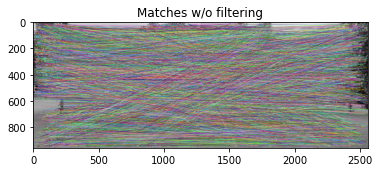

In [6]:
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2,
                      matches, None,
                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(res)
plt.title('Matches w/o filtering')
plt.show()

### 1.3. Se filtran los matches

In [7]:
matches = descriptors.filter_matches(method=method_filter_matches, matches=matches,min_distance=min_d)

points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt

Se dibujan los matches filtrados

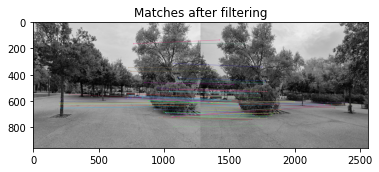

In [8]:
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2,
                      matches, None,
                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(res)
plt.title('Matches after filtering')
plt.show()

## 1.4 Se realiza la homografía de la imagen derecha para encajarla después en la izquierda.

In [9]:
# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

In [10]:
# Use homography
height, width = img_R_g.shape
im1Reg = cv2.warpPerspective(img_L_g, h, (width, height))

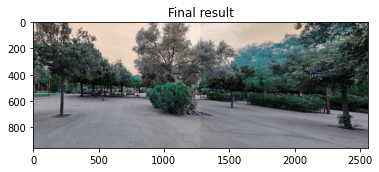

In [11]:
dst = cv2.warpPerspective(img_R,h,(img_L.shape[1] + img_R.shape[1], img_L.shape[0]))
dst[0:img_L.shape[0], 0:img_L.shape[1]] = img_L
cv2.imwrite('../out/surf1.jpg',dst)
plt.imshow(dst)
plt.title('Final result')
plt.show()

A partir de ahora se ejecutan las celdas anteriores en una sola celda y se muestra el resultado al final.

## 2."surf"+"BF_k"+"KNN"

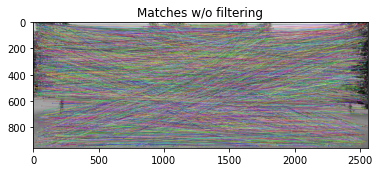

852


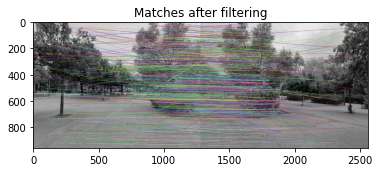

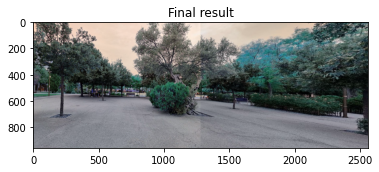

In [12]:
#Select method, matching and filtering
method_kp_desc = "surf"
k_match = 2 #se utiliza cuando se piden los k vecinos más cercanos
method_match = "BF_k"
method_filter_matches = "KNN"
#min_d = 0.1 
proportion = 0.8 #se utiliza cuando se piden los k vecinos más cercanos

#Calculate keypoints and descriptors
kp1, desc1 = descriptors.get_kp_desc(method=method_kp_desc, img=img_L_g)
kp2, desc2 = descriptors.get_kp_desc(method=method_kp_desc, img=img_R_g)

#Calculate matches
matches = descriptors.match_descriptors(method=method_match, desc1=desc1, desc2=desc2, k=k_match)


#Draw matches without filtering
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2, [m[0] for m in matches], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(res)
plt.title('Matches w/o filtering')
plt.show()

#Filter the matches
matches = descriptors.filter_matches(method=method_filter_matches, matches=matches, proportion=proportion)
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match[0].queryIdx].pt
    points2[i, :] = kp2[match[0].trainIdx].pt
print(len(matches))

#Draw mathces after filtering
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2,
                      [m[0] for m in matches], None,
                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(res)
plt.title('Matches after filtering')
plt.show()



# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography
height, width = img_R_g.shape
im1Reg = cv2.warpPerspective(img_L_g, h, (width, height))

#Stitch the images
dst = cv2.warpPerspective(img_R,h,(img_L.shape[1] + img_R.shape[1], img_L.shape[0]))
dst[0:img_L.shape[0], 0:img_L.shape[1]] = img_L
cv2.imwrite('../out/surf2.jpg',dst)
plt.imshow(dst)
plt.title('Final result')
plt.show()

## 3."sift"+"BF"+"DIST"

10079


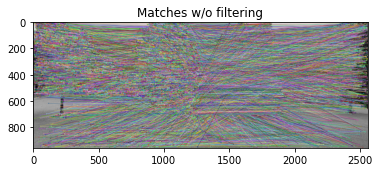

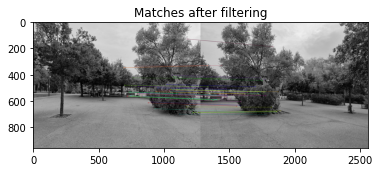

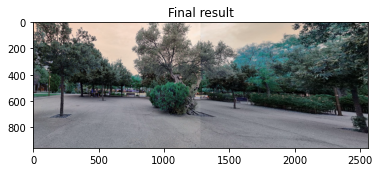

In [13]:
#Select method, matching and filtering
method_kp_desc = "sift"
#k_match = 2 #se utiliza cuando se piden los k vecinos más cercanos
method_match = "BF"
method_filter_matches = "DIST"
min_d = 100
#proportion = 0.8 #se utiliza cuando se piden los k vecinos más cercanos

#Calculate keypoints and descriptors
kp1, desc1 = descriptors.get_kp_desc(method=method_kp_desc, img=img_L_g)
kp2, desc2 = descriptors.get_kp_desc(method=method_kp_desc, img=img_R_g)

#Calculate matches
matches = descriptors.match_descriptors(method=method_match, desc1=desc1, desc2=desc2)
print(len(matches))

#Draw matches without filtering
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2, matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(res)
plt.title('Matches w/o filtering')
plt.show()

#Filter the matches
matches = descriptors.filter_matches(method=method_filter_matches, matches=matches, min_distance=min_d)
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt


#Draw mathces after filtering
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2,
                      matches, None,
                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(res)
plt.title('Matches after filtering')
plt.show()



# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography
height, width = img_R_g.shape
im1Reg = cv2.warpPerspective(img_L_g, h, (width, height))

#Stitch the images
dst = cv2.warpPerspective(img_R,h,(img_L.shape[1] + img_R.shape[1], img_L.shape[0]))
dst[0:img_L.shape[0], 0:img_L.shape[1]] = img_L
cv2.imwrite('../out/sift1.jpg',dst)
plt.imshow(dst)
plt.title('Final result')
plt.show()

## 4."sift"+"BF_k"+"KNN"

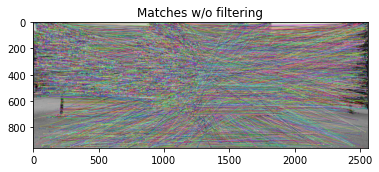

810


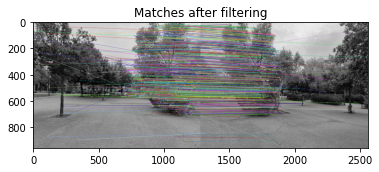

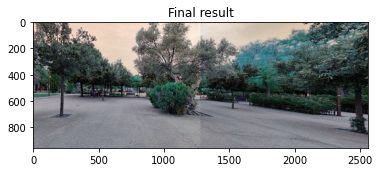

In [14]:
#Select method, matching and filtering
method_kp_desc = "sift"
k_match = 2 #se utiliza cuando se piden los k vecinos más cercanos
method_match = "BF_k"
method_filter_matches = "KNN"
#min_d = 0.1 
proportion = 0.8 #se utiliza cuando se piden los k vecinos más cercanos

#Calculate keypoints and descriptors
kp1, desc1 = descriptors.get_kp_desc(method=method_kp_desc, img=img_L_g)
kp2, desc2 = descriptors.get_kp_desc(method=method_kp_desc, img=img_R_g)

#Calculate matches
matches = descriptors.match_descriptors(method=method_match, desc1=desc1, desc2=desc2, k=k_match)


#Draw matches without filtering
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2, [m[0] for m in matches], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(res)
plt.title('Matches w/o filtering')
plt.show()

#Filter the matches
matches = descriptors.filter_matches(method=method_filter_matches, matches=matches, proportion=proportion)
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match[0].queryIdx].pt
    points2[i, :] = kp2[match[0].trainIdx].pt
print(len(matches))

#Draw mathces after filtering
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2,
                      [m[0] for m in matches], None,
                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(res)
plt.title('Matches after filtering')
plt.show()



# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography
height, width = img_R_g.shape
im1Reg = cv2.warpPerspective(img_L_g, h, (width, height))

#Stitch the images
dst = cv2.warpPerspective(img_R,h,(img_L.shape[1] + img_R.shape[1], img_L.shape[0]))
dst[0:img_L.shape[0], 0:img_L.shape[1]] = img_L
cv2.imwrite('../out/sift2.jpg',dst)
plt.imshow(dst)
plt.title('Final result')
plt.show()

## 5."O"+"BF_H"+"DIST"

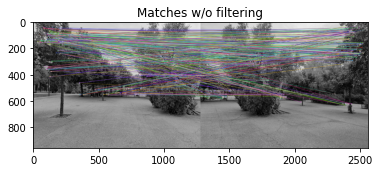

58


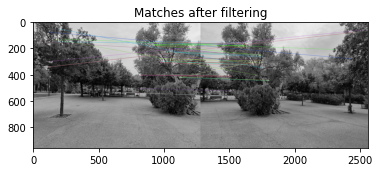

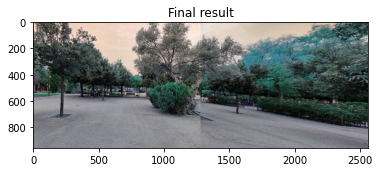

In [15]:
#Select method, matching and filtering
method_kp_desc = "O"
#k_match = 2 #se utiliza cuando se piden los k vecinos más cercanos
method_match = "BF_H"
method_filter_matches = "DIST"
min_d = 55
#proportion = 0.8 #se utiliza cuando se piden los k vecinos más cercanos

#Calculate keypoints and descriptors
kp1, desc1 = descriptors.get_kp_desc(method=method_kp_desc, img=img_L_g)
kp2, desc2 = descriptors.get_kp_desc(method=method_kp_desc, img=img_R_g)

#Calculate matches
matches = descriptors.match_descriptors(method=method_match, desc1=desc1, desc2=desc2)


#Draw matches without filtering
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2, matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(res)
plt.title('Matches w/o filtering')
plt.show()

#Filter the matches
matches = descriptors.filter_matches(method=method_filter_matches, matches=matches, min_distance=min_d)
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt
print(len(matches))

#Draw mathces after filtering
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2,
                      matches, None,
                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(res)
plt.title('Matches after filtering')
plt.show()



# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography
height, width = img_R_g.shape
im1Reg = cv2.warpPerspective(img_L_g, h, (width, height))

#Stitch the images
dst = cv2.warpPerspective(img_R,h,(img_L.shape[1] + img_R.shape[1], img_L.shape[0]))
dst[0:img_L.shape[0], 0:img_L.shape[1]] = img_L
cv2.imwrite('../out/orb1.jpg',dst)
plt.imshow(dst)
plt.title('Final result')
plt.show()

## 6."O"+"BF_H_k"+"KNN"

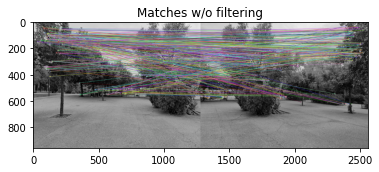

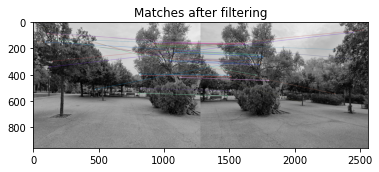

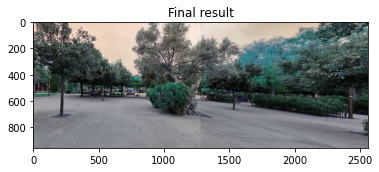

In [16]:
#Select method, matching and filtering
method_kp_desc = "O"
k_match = 2 #se utiliza cuando se piden los k vecinos más cercanos
method_match = "BF_H_k"
method_filter_matches = "KNN"
#min_d = 0.1 
proportion = 0.8 #se utiliza cuando se piden los k vecinos más cercanos

#Calculate keypoints and descriptors
kp1, desc1 = descriptors.get_kp_desc(method=method_kp_desc, img=img_L_g)
kp2, desc2 = descriptors.get_kp_desc(method=method_kp_desc, img=img_R_g)

#Calculate matches
matches = descriptors.match_descriptors(method=method_match, desc1=desc1, desc2=desc2, k=k_match)


#Draw matches without filtering
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2, [m[0] for m in matches], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(res)
plt.title('Matches w/o filtering')
plt.show()

#Filter the matches
matches = descriptors.filter_matches(method=method_filter_matches, matches=matches, proportion=proportion)
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match[0].queryIdx].pt
    points2[i, :] = kp2[match[0].trainIdx].pt

#Draw mathces after filtering
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2,
                      [m[0] for m in matches], None,
                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(res)
plt.title('Matches after filtering')
plt.show()


# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography
height, width = img_R_g.shape
im1Reg = cv2.warpPerspective(img_L_g, h, (width, height))

#Stitch the images
dst = cv2.warpPerspective(img_R,h,(img_L.shape[1] + img_R.shape[1], img_L.shape[0]))
dst[0:img_L.shape[0], 0:img_L.shape[1]] = img_L
cv2.imwrite('../out/orb2.jpg',dst)
plt.imshow(dst)
plt.title('Final result')
plt.show()

## 7."fast_brief"+"BF_H"+"DIST"

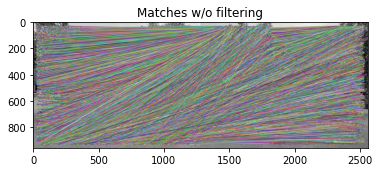

3185


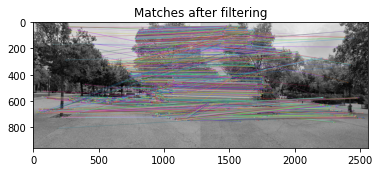

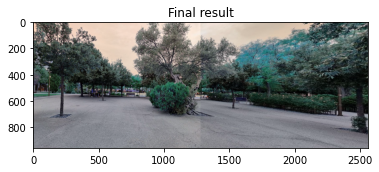

In [17]:
#Select method, matching and filtering
method_kp_desc = "fast_brief"
#k_match = 2 #se utiliza cuando se piden los k vecinos más cercanos
method_match = "BF_H"
method_filter_matches = "DIST"
min_d = 20
#proportion = 0.8 #se utiliza cuando se piden los k vecinos más cercanos

#Calculate keypoints and descriptors
kp1, desc1 = descriptors.get_kp_desc(method=method_kp_desc, img=img_L_g)
kp2, desc2 = descriptors.get_kp_desc(method=method_kp_desc, img=img_R_g)

#Calculate matches
matches = descriptors.match_descriptors(method=method_match, desc1=desc1, desc2=desc2)


#Draw matches without filtering
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2, matches, None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(res)
plt.title('Matches w/o filtering')
plt.show()

#Filter the matches
matches = descriptors.filter_matches(method=method_filter_matches, matches=matches, min_distance=min_d)
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt
print(len(matches))

#Draw mathces after filtering
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2,
                      matches, None,
                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(res)
plt.title('Matches after filtering')
plt.show()



# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography
height, width = img_R_g.shape
im1Reg = cv2.warpPerspective(img_L_g, h, (width, height))

#Stitch the images
dst = cv2.warpPerspective(img_R,h,(img_L.shape[1] + img_R.shape[1], img_L.shape[0]))
dst[0:img_L.shape[0], 0:img_L.shape[1]] = img_L
cv2.imwrite('../out/fastbrief1.jpg',dst)
plt.imshow(dst)
plt.title('Final result')
plt.show()

## 8."fast_brief"+"BF_H_k"+"KNN"

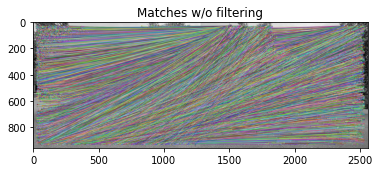

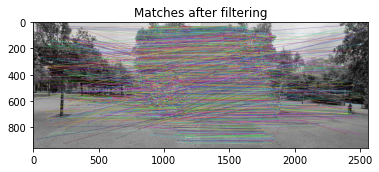

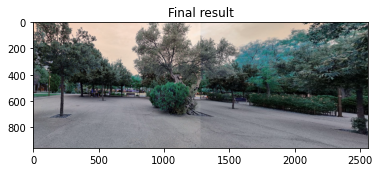

In [18]:
#Select method, matching and filtering
method_kp_desc = "fast_brief"
k_match = 2 #se utiliza cuando se piden los k vecinos más cercanos
method_match = "BF_H_k"
method_filter_matches = "KNN"
#min_d = 0.1 
proportion = 0.8 #se utiliza cuando se piden los k vecinos más cercanos

#Calculate keypoints and descriptors
kp1, desc1 = descriptors.get_kp_desc(method=method_kp_desc, img=img_L_g)
kp2, desc2 = descriptors.get_kp_desc(method=method_kp_desc, img=img_R_g)

#Calculate matches
matches = descriptors.match_descriptors(method=method_match, desc1=desc1, desc2=desc2, k=k_match)

#Draw matches without filtering
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2, [m[0] for m in matches], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(res)
plt.title('Matches w/o filtering')
plt.show()

#Filter the matches
matches = descriptors.filter_matches(method=method_filter_matches, matches=matches, proportion=proportion)
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp1[match[0].queryIdx].pt
    points2[i, :] = kp2[match[0].trainIdx].pt

#Draw mathces after filtering
res = cv2.drawMatches(img_L_g, kp1, img_R_g, kp2,
                      [m[0] for m in matches], None,
                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(res)
plt.title('Matches after filtering')
plt.show()


# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# Use homography
height, width = img_R_g.shape
im1Reg = cv2.warpPerspective(img_L_g, h, (width, height))

#Stitch the images
dst = cv2.warpPerspective(img_R,h,(img_L.shape[1] + img_R.shape[1], img_L.shape[0]))
dst[0:img_L.shape[0], 0:img_L.shape[1]] = img_L
cv2.imwrite('../out/fastbrief2.jpg',dst)
plt.imshow(dst)
plt.title('Final result')
plt.show()

# Comentarios finales
Después de realizar el image stitching parece que el método "fast_brief" es el que tarda más tarde en ejecutarse a pesar de que los descriptores que se obtienen son en binario. Esto puede ser debido a que el algortimo FAST detecta muchos más *keypoints* (ya sea correctos o incorrectos) que los demás algoritmos. Para demostrar esto, se debería realizar una medición del tiempo que tarda cada algoritmo en obtener los *keypoints* y *descriptors* y luego realizar el *matching* de estos. Por otro lado, para cada par de imágenes que se quieren unir es necesario cambiar el valor de *proportion* o *min_distanci*a, incluso dependiendo de la elección de los algoritmos y las imágenes es posible que sea muy difícil encontrar los matches correctos. También se ha detectado que el tiempo de cálculo de matches puede demorarse mucho si el tamaño de la imagen es muy grande. Se ha dado el caso que una imagen de gran tamaño el algoritmo FAST+BRIEF que se ha implementado no funcionaba, en cambio, la misma imagen reducida en tamaño sí. Este es el caso, por ejemplo, de olivo_R.jpg y olivo_L.jpg que son las imágenes reducidas de olivo_R_original.jpg y olivo_L_original.jpg. 

Notebook realizado por Janusz Szturo para la asignatura de Visión por Computador y Reconstrucción 3D del Máster en Sistemas Inteligentes de la Universidad de las Islas Baleares.
GitHub: https://github.com/JanuszJSzturo/vpc_descriptors